# Assignmnet 3 (100 + 5 points)

**Name: Daniel Shaquille** <br>
**Email: das9688@thi.de** <br>
**Group: B**<br>
**Hours spend *(optional)* : 3 Weeks** <br>

### Question 1: Transformer model *(100 points)*

As a Machine Learning engineer at a tech company, you were given a task to develop a machine translation system that translates **English (source) to German (Target)**. You can use existing libraries but the training needs to be done from scratch (usage of pretrained weights is not allowed). You have the freedom to select any dataset for training the model. Use a small subset of data as a validation dataset and report the BLEU score on the validation set. Also, provide a short description of your transformer model architecture, hyperparameters, and training (also provide the training loss curve).

<h3> Submission </h3>

The test set **(test.txt)** will be released one week before the deadline. You should submit the output of your model on the test set separately. Name the output file as **"first name_last_name_test_result.txt"**. Each line of the submission file should contain only the translated text of the corresponding sentence from 'test.txt'.

The 'first name_last_name_test_result.txt' file will be evaluated by your instructor and the student who could get the best BLEU score will get 5 additional points.

**Dataset**

Here are some of the parallel datasets (see Datasets and Resources file):
* Europarl Parallel corpus - https://www.statmt.org/europarl/v7/de-en.tgz
* News Commentary - https://www.statmt.org/wmt14/training-parallel-nc-v9.tgz (use DE-EN parallel data)
* Common Crawl corpus - https://www.statmt.org/wmt13/training-parallel-commoncrawl.tgz (use DE-EN parallel data)

You can also use other datasets of your choice. In the above datasets, **'.en'** file has the text in English, and **'.de'** file contains their corresponding German translations.

## Notes:

1) You can also consider using a small subset of the dataset if the training dataset is large
2) Sometimes you can also get out of memory errors while training, so choose the hyperparameters carefully.
3) Your training will be much faster if you use a GPU. If you are using a CPU, it may take several hours or even days. (you can also use Google Colab GPUs for training. link: https://colab.research.google.com/)

In [14]:
import spacy
from torchtext.data.utils import get_tokenizer
import sacrebleu
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertConfig, BertModel, BertTokenizer
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from collections import Counter
import string
from tqdm import tqdm


In [15]:
'''
Convert english and german text into tokens
Then read the english and german files 
Need to ensure that the lines are same in both files that the english and german sentences corresponds
Create a panda dataframe with english and german as columns
Then split the data into train and validation dataset with 90/10 split
Take a fraction of our data in the train and validate to save time

'''

english_tokenized = BertTokenizer.from_pretrained('bert-base-uncased')
german_tokenized = BertTokenizer.from_pretrained('bert-base-german-cased')


english_file = 'news-commentary-v9.de-en.en'
german_file = 'news-commentary-v9.de-en.de'

with open(english_file, 'r', encoding='utf-8') as f:
    english_sts = f.readlines()

with open(german_file, 'r', encoding='utf-8') as f:
    german_sts = f.readlines()

shorten_length = min(len(english_sts), len(german_sts))
english_sts = english_sts[:shorten_length]
german_sts = german_sts[:shorten_length]

data = pd.DataFrame({'en': english_sts, 'de': german_sts})

training_data, validation_data = train_test_split(data, test_size=0.1, random_state=42)


training_data_length = training_data.sample(frac=0.015, random_state=67)
validation_data_length = validation_data.sample(frac=0.015, random_state=67)

print(f"Training data sample size: {len(training_data_length)}")
print(f"Validation data sample size: {len(validation_data_length)}")
print(data)



Training data sample size: 2725
Validation data sample size: 303
                                                       en   
0                                         $10,000 Gold?\n  \
1       SAN FRANCISCO – It has never been easy to have...   
2       Lately, with gold prices up more than 300% ove...   
3       Just last December, fellow economists Martin F...   
4                                 Wouldn’t you know it?\n   
...                                                   ...   
201849                   It didn’t have to be this way.\n   
201850  This past year has seen one missed opportunity...   
201851  South African president Thabo Mbeki convened n...   
201852  Some African leaders – notably Ghana’s preside...   
201853  Perhaps more significantly, the international ...   

                                                       de  
0                        Steigt Gold auf 10.000 Dollar?\n  
1       SAN FRANCISCO – Es war noch nie leicht, ein ra...  
2       In letzter Zei

In [16]:

'''
Inherit the pytorch Dataset into our TransformerModelLanguageTranslator class.
This is to handle the preparation of the data for the model.
The __len__ method will return the number of samples.
The __getitem__ method will get a sample from the dataset.
The english text that was fetched will be tokenized.
self.for_test will be used when the for_test boolean is True and is used forr the testing dataset
When not dealing with any test dataset, the german text that was fetched will be tokenized.
Then create our training and validation Datasets and DataLoaders.
'''


class LanguageTranslatorDataset(Dataset):
    def __init__(self, data, english_tokenized, german_tokenized, maximum_length, for_test=False):
        self.data = data
        self.english_tokenized = english_tokenized
        self.german_tokenized = german_tokenized
        self.maximum_length = maximum_length
        self.for_test = for_test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        english_text = self.data.iloc[idx, 0].strip()
        english_tokens = self.english_tokenized(
            english_text,
            max_length=self.maximum_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        if self.for_test:
            return {
                'input_ids': english_tokens['input_ids'].squeeze(),
                'attention_mask': english_tokens['attention_mask'].squeeze(),
                'en_text': english_text
            }

        german_text = self.data.iloc[idx, 1].strip()
        german_tokens = self.german_tokenized(
            german_text,
            max_length=self.maximum_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': english_tokens['input_ids'].squeeze(),
            'attention_mask': english_tokens['attention_mask'].squeeze(),
            'target_ids': german_tokens['input_ids'].squeeze(),
            'target_attention_mask': german_tokens['attention_mask'].squeeze()
        }

maximum_length_parameter = 128
batch_size_parameter = 16

training_samples_of_datasets = LanguageTranslatorDataset(training_data_length, english_tokenized, german_tokenized, maximum_length_parameter)
training_samples_of_dataloader = DataLoader(training_samples_of_datasets, batch_size=batch_size_parameter, shuffle=True)

validation_samples_of_datasets = LanguageTranslatorDataset(validation_data_length, english_tokenized, german_tokenized, maximum_length_parameter)
validation_samples_of_dataloader = DataLoader(validation_samples_of_datasets, batch_size=batch_size_parameter, shuffle=False)

In [17]:

'''
Creating our own custome made transformer model for translating english-german language.
Hyperparameters that were being used and initialzed are: the english and german vocab size, the BERT model hidden size,
the number of hidden layers, number of attention heads, dimension of the feedforward network, dropout rate and device.
We then create the configuration object for the BERT and used those parameters as mentioned above.
self.encoder for the english language and self.decoder for the german language
Our self.fully_connected_out is the linear layer that will map the decoder outputs towards the output vocabulary size.
Dropout is for regularization to reduce overfitting.
Have the forward path method.
The source encoder will pass the source inputs to the encoder.
The target decoder will pass the target inputs to the decoder.
The decoder outputs will be applied towards the fully connected out for predictions.
Adam as Optimizer and Cross Entropy loss as the loss function.

'''


class TransformerModelLanguageTranslator(nn.Module):
    def __init__(self, dimension_of_input, dimension_of_output, dimension_of_hidden, number_of_hidden_layers, number_of_attention_heads, dimension_of_ffn, dropout, device):
        super().__init__()

        self.device = device

        config = BertConfig(
            vocab_size=dimension_of_input,
            hidden_size=dimension_of_hidden,
            num_hidden_layers=number_of_hidden_layers,
            num_attention_heads=number_of_attention_heads,
            intermediate_size=dimension_of_ffn,
            hidden_dropout_prob=dropout,
            attention_probs_dropout_prob=dropout
        )

        self.encoder = BertModel(config)
        self.decoder = BertModel(config)

        self.fully_connected_out = nn.Linear(dimension_of_hidden, dimension_of_output)

        self.dropout = nn.Dropout(dropout)

    def forward(self, source, target, source_mask, target_mask):
        source_encoder = self.encoder(source, attention_mask=source_mask)[0]
        target_decoder = self.decoder(target, attention_mask=target_mask)[0]

        output = self.fully_connected_out(target_decoder)

        return output

dimension_of_input = len(english_tokenized) 
dimension_of_output = len(german_tokenized)  
dimension_of_hidden = 768 
number_of_hidden_layers = 6
number_of_attention_heads = 6
dimension_of_pf = 1024
dropout = 0.5

device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
model = TransformerModelLanguageTranslator(dimension_of_input, dimension_of_output, dimension_of_hidden, number_of_hidden_layers, number_of_attention_heads, dimension_of_pf, dropout, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_function = nn.CrossEntropyLoss(ignore_index=german_tokenized.pad_token_id)



In [20]:
'''Model Training and Evaluation'''

'''
The training_model_function will train our model.
The loop will iterate each batch of data that was being provided from the training DataLoader
Here there is also gradient clipping to avoid exploding gradients
Output the average loss of our model in every epoch

'''


def training_model_function(model, iterate, optimizer, loss_function, clipping, epoch):
    model.train()

    loss_of_epoch = 0

    for i, b in tqdm(enumerate(iterate, 0), total=np.ceil(len(iterate.dataset) / iterate.batch_size), desc=f"Training Epoch {epoch+1}", leave=False, colour='blue'):
        source = b['input_ids'].to(device)
        target = b['target_ids'].to(device)

        source_mask = b['attention_mask'].to(device)
        target_mask = b['target_attention_mask'].to(device)

        optimizer.zero_grad()

        output = model(source, target, source_mask, target_mask)

        output_of_dimension = output.shape[-1]

        output = output.contiguous().view(-1, output_of_dimension)
        target = target.contiguous().view(-1)

        loss = loss_function(output, target)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clipping)

        optimizer.step()

        loss_of_epoch += loss.item()

    return loss_of_epoch / len(iterate)

def evaluation_model_function(model, iterate, loss_function, epoch):
    model.eval()

    loss_of_epoch = 0
    all_our_references = []
    all_our_hypotheses = []

    with torch.no_grad():
        for i, b in tqdm(enumerate(iterate, 0), total=np.ceil(len(iterate.dataset) / iterate.batch_size), desc=f"Validation Epoch {epoch+1}", leave=False, colour='green'):
            source = b['input_ids'].to(device)
            target = b['target_ids'].to(device)

            source_mask = b['attention_mask'].to(device)
            target_mask = b['target_attention_mask'].to(device)

            output = model(source, target, source_mask, target_mask)

            output_ids = torch.argmax(output, dim=-1)

            loss = loss_function(output.view(-1, output.shape[-1]), target.view(-1))
            loss_of_epoch += loss.item()

            target_sentences = [german_tokenized.decode(t[:target_mask[i].sum()].cpu().numpy()) for i, t in enumerate(target)]
            output_sentences = [german_tokenized.decode(o[:target_mask[i].sum()].cpu().numpy()) for i, o in enumerate(output_ids)]

            # print(f"Target sentence: {trg_sentences[:5]}")
            # print(f"Output sentence: {output_sentences[:5]}")

            all_our_references.extend(target_sentences)
            all_our_hypotheses.extend(output_sentences)

    blue_score = sacrebleu.corpus_bleu(all_our_hypotheses, [all_our_references])
    return loss_of_epoch / len(iterate), blue_score.score



Epoch: 01


Saving the best model at epoch 1 that has validation loss 4.042
	Training Loss: 6.120
	 Validation Loss: 4.042
	BLEU Score: 25.83
Epoch: 02


Saving the best model at epoch 2 that has validation loss 2.683
	Training Loss: 3.770
	 Validation Loss: 2.683
	BLEU Score: 47.46
Epoch: 03


Saving the best model at epoch 3 that has validation loss 1.863
	Training Loss: 2.688
	 Validation Loss: 1.863
	BLEU Score: 66.33
Epoch: 04


Saving the best model at epoch 4 that has validation loss 1.384
	Training Loss: 1.904
	 Validation Loss: 1.384
	BLEU Score: 75.59
Epoch: 05


Saving the best model at epoch 5 that has validation loss 1.090
	Training Loss: 1.334
	 Validation Loss: 1.090
	BLEU Score: 83.31
Epoch: 06


Saving the best model at epoch 6 that has validation loss 0.920
	Training Loss: 0.931
	 Validation Loss: 0.920
	BLEU Score: 86.22
Epoch: 07


Saving the best model at epoch 7 that has validation loss 0.816
	Training Loss: 0.646
	 Validation Loss: 0.816
	BLEU Score: 86.54
Epoch: 08


Saving the best model at epoch 8 that has validation loss 0.743
	Training Loss: 0.442
	 Validation Loss: 0.743
	BLEU Score: 86.69
Epoch: 09


Saving the best model at epoch 9 that has validation loss 0.698
	Training Loss: 0.305
	 Validation Loss: 0.698
	BLEU Score: 86.71
Epoch: 10


Saving the best model at epoch 10 that has validation loss 0.673
	Training Loss: 0.212
	 Validation Loss: 0.673
	BLEU Score: 86.73


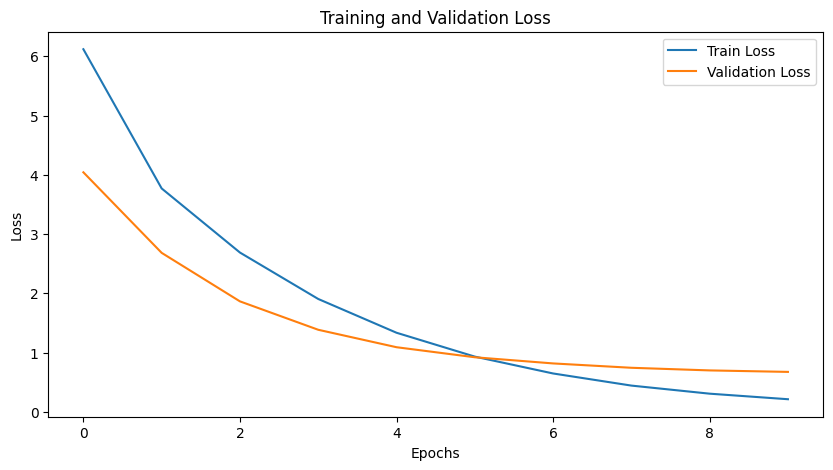

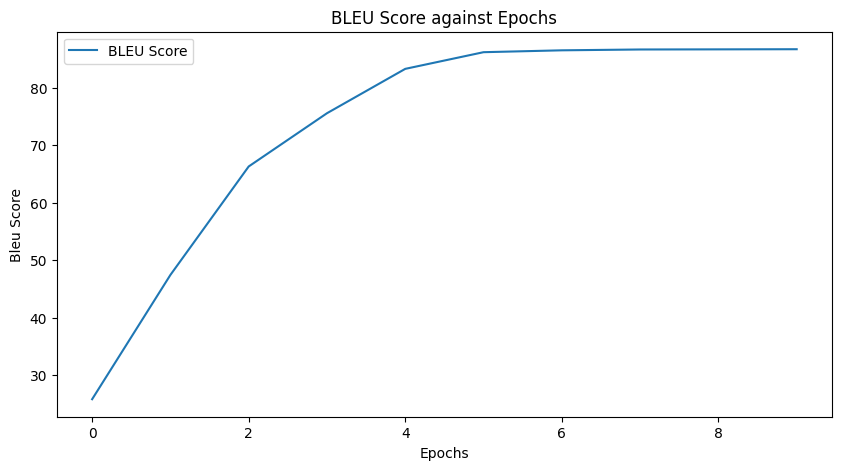

In [21]:
number_of_epochs = 10
clipping = 1

losses_in_training = []
losses_in_validating = []
bleu_score_lists = []

count_validation_loss = float('inf')

for epoch in range(number_of_epochs):
    print(f'Epoch: {epoch+1:02}')

    training_loss = training_model_function(model, training_samples_of_dataloader, optimizer, loss_function, clipping, epoch)
    validation_loss, score_of_bleu = evaluation_model_function(model, validation_samples_of_dataloader, loss_function, epoch)

    losses_in_training.append(training_loss)
    losses_in_validating.append(validation_loss)
    bleu_score_lists.append(score_of_bleu)

    if validation_loss < count_validation_loss:
        highest_validation_loss = validation_loss
        torch.save(model.state_dict(), 'best-model.pt')
        print(f'Saving the best model at epoch {epoch+1} that has validation loss {validation_loss:.3f}')

    print(f'\tTraining Loss: {training_loss:.3f}')
    print(f'\t Validation Loss: {validation_loss:.3f}')
    print(f'\tBLEU Score: {score_of_bleu:.2f}')

plt.figure(figsize=(10, 5))
plt.plot(range(number_of_epochs), losses_in_training, label='Train Loss')
plt.plot(range(number_of_epochs), losses_in_validating, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(number_of_epochs), bleu_score_lists, label='BLEU Score')
plt.xlabel('Epochs')
plt.ylabel('Bleu Score')
plt.legend()
plt.title('BLEU Score against Epochs')
plt.show()

In [ ]:
english_test_file = 'test.en'

with open(english_test_file, 'r', encoding='utf-8') as f:
    english_test_sentences = f.readlines()

test_data = pd.DataFrame({'en': english_test_sentences})

test_text_dataset = LanguageTranslatorDataset(test_data, english_tokenized, german_tokenized, maximum_length_parameter, for_test=True)
test_text_dataloader = DataLoader(test_text_dataset, batch_size=batch_size_parameter, shuffle=False)

model.load_state_dict(torch.load('best-model.pt'))

def test_sentences_translator(model, iterate, german_tokenized):
    model.eval()
    all_our_hypotheses = []
    all_our_inputs = []

    with torch.no_grad():
        for i, b in tqdm(enumerate(iterate, 0), total=np.ceil(len(iterate.dataset) / iterate.batch_size), desc="Translating", leave=False, colour='yellow'):
            src = b['input_ids'].to(device)
            src_mask = b['attention_mask'].to(device)

            output = model.encoder(src, attention_mask=src_mask)[0]
            output_ids = torch.argmax(output, dim=-1)

            output_german_sentences = [german_tokenized.decode(o[:src_mask[i].sum()].cpu().numpy(), skip_special_tokens=True) for i, o in enumerate(output_ids)]
            all_our_hypotheses.extend(output_german_sentences)
            all_our_inputs.extend(b['en_text'])

    return all_our_inputs, all_our_hypotheses

english_language_texts, translated_sentences = test_sentences_translator(model, test_text_dataloader, german_tokenized)

translated_file = 'translated_german.txt'

with open(translated_file, 'w', encoding='utf-8') as f:
    for english, german in zip(english_language_texts, translated_sentences):
        f.write(f"German: {german.strip()}\n")



In [ ]:
'''
Due to limited computational power, I only managed to train my model by using my CPU
Therefore I used only a small dataset to train and validate my model
Because of that the performance of my model with the test dataset was poor
Other reasons of poor performance with the test set may be due to choices of hyperparameter
Searching for the best hyperparameter requires a strong GPU especially when training a language translation model 
'''

'''
References and citations used for this assignment:

ChatGPT
https://arusl.medium.com/japanese-english-language-translation-with-transformer-using-pytorch-243738146806
https://huggingface.co/docs/transformers/en/tasks/translation#load-opus-books-dataset
https://www.youtube.com/watch?v=DkzbCJtFvqM
https://medium.com/data-and-beyond/complete-guide-to-building-bert-model-from-sratch-3e6562228891
https://medium.com/@avinashmachinelearninginfo/hands-on-with-bert-model-c77a27b9839b



'''